# Exploratory data analysis: Wine quality data

In [1]:
# Required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import probplot

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from typing import Tuple


In [2]:
# Import raw data
raw_data = pd.read_csv("../data/winequalityN.csv")
raw_data.head()

raw_data = pd.get_dummies(raw_data)
raw_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


## Data overview

In [3]:
raw_data.shape

(6497, 14)

In [4]:
raw_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type_red                  uint8
type_white                uint8
dtype: object

In [5]:
raw_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


## Data cleaning

### Missing values

In [6]:
def check_null_values(data : pd.DataFrame()) -> pd.DataFrame():
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(
        ascending=False
    )
    missing_data = pd.concat([total, percent * 100], axis=1, keys=["Total", "Percent"])
    return missing_data

In [7]:
check_null_values(raw_data)

,Total,Percent
fixed acidity,10,0.153917
pH,9,0.138525
volatile acidity,8,0.123134
sulphates,4,0.061567
citric acid,3,0.046175
residual sugar,2,0.030783
chlorides,2,0.030783
free sulfur dioxide,0,0.000000
total sulfur dioxide,0,0.000000
density,0,0.000000


### Impute missing values

In [8]:
raw_data_columns  = raw_data.columns 

imputer = SimpleImputer(strategy='mean')
raw_data = pd.DataFrame(imputer.fit_transform(raw_data))
raw_data.columns = raw_data_columns

In [9]:
check_null_values(raw_data)

,Total,Percent
fixed acidity,0,0.0
volatile acidity,0,0.0
citric acid,0,0.0
residual sugar,0,0.0
chlorides,0,0.0
free sulfur dioxide,0,0.0
total sulfur dioxide,0,0.0
density,0,0.0
pH,0,0.0
sulphates,0,0.0


## Data exploration

### Feature selection

#### Correlation between variables

In [10]:
   def plot_corr_matrix(df : pd.DataFrame(), size : Tuple) -> None:
        corr = df.corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        f, ax = plt.subplots(figsize=size)
        cmap = sns.diverging_palette(230,20, as_cmap=True)
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"size":10})
        plt.show()


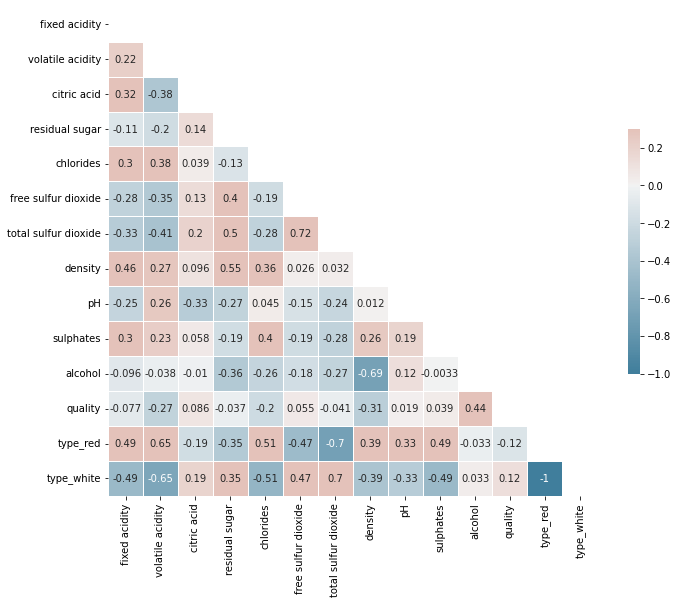

In [11]:
plot_corr_matrix(df=raw_data, size=(11,9))

Check for causality on correlated features:
- Volatile acidity: Refers to the acidic elements of a wine that are gaseous, rather than liquid, and therefore can be sensed as a smell.
- Chlorides: Contribute to saltiness on taste.
- Density: How grape concentrated is the wine during fermentation.
- Alchohol: How alcohol concentrated is the wine.
- Red or white: Type of wine.

It looks that all are features that cause an effect on wine quality.

In [12]:
corr_feats = ['volatile acidity', 'chlorides', 'density', 'alcohol', 'type_red', 'type_white', 'quality']
wine_df = raw_data[corr_feats] 
wine_df.shape



(6497, 7)

### Numeric distributions

In [18]:
def feature_normality_analysis(df : pd.DataFrame(), feature : str, size: Tuple) -> None:
    f, ax = plt.subplots(1, 2, figsize = size)
    sns.distplot(df[feature], fit=norm, ax=ax[0]).set(title=f'{feature} normalized histogram')
    res = probplot(df[feature], plot=ax[1])
    
    f.suptitle(f'{feature} normality analysis')
    plt.show()
    

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


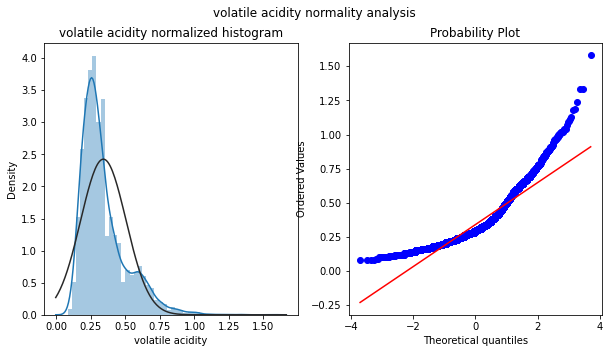

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


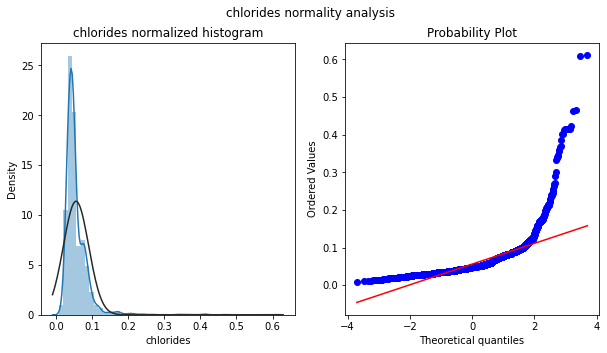

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


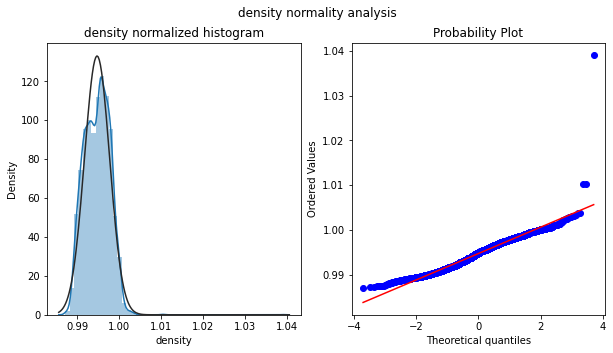

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


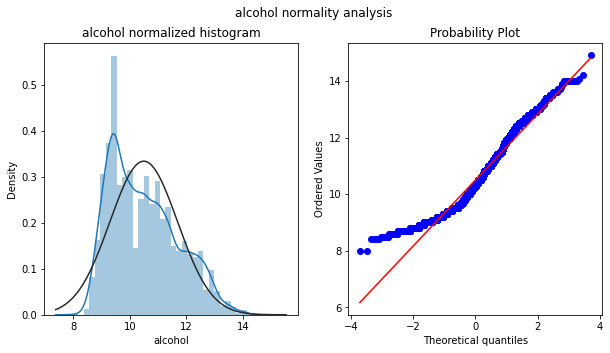

In [19]:
num_features = ['volatile acidity', 'chlorides', 'density', 'alcohol']
for feature in num_features:
    feature_normality_analysis(wine_df, feature, (10,5))

In [15]:
wine_df.describe()

,volatile acidity,chlorides,density,alcohol,type_red,type_white,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,0.339691,0.056042,0.994697,10.491801,0.246114,0.753886,5.818378
std,0.164548,0.035031,0.002999,1.192712,0.430779,0.430779,0.873255
min,0.080000,0.009000,0.987110,8.000000,0.000000,0.000000,3.000000
25%,0.230000,0.038000,0.992340,9.500000,0.000000,1.000000,5.000000
50%,0.290000,0.047000,0.994890,10.300000,0.000000,1.000000,6.000000
75%,0.400000,0.065000,0.996990,11.300000,0.000000,1.000000,6.000000
max,1.580000,0.611000,1.038980,14.900000,1.000000,1.000000,9.000000


## Processing the data

### Bivariate analysis

In [16]:
def bivariate_analize(df : pd.DataFrame(), feature : str, target : str, size : Tuple) -> None:
    fig, ax = plt.subplots(figsize=size)
    sns.scatterplot(x=df[feature], y=df[target], ax=ax).set(
    title=f'{target} v {feature}')
    plt.show()

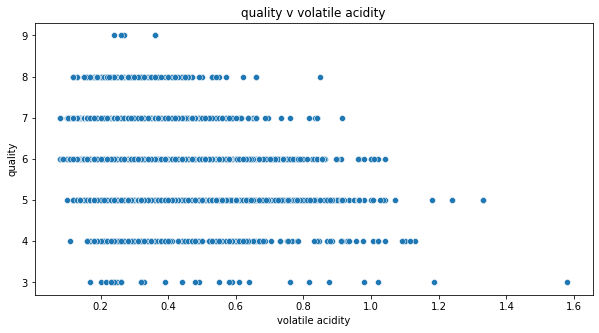

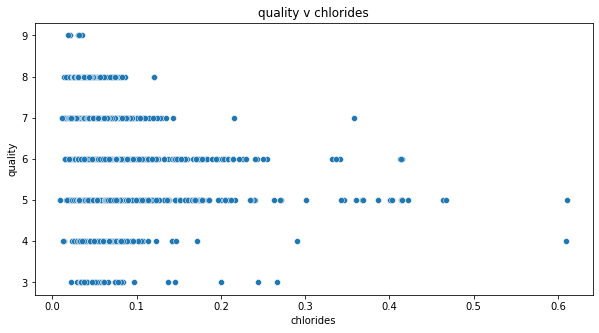

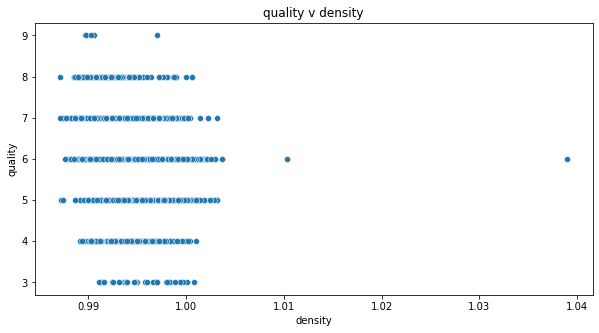

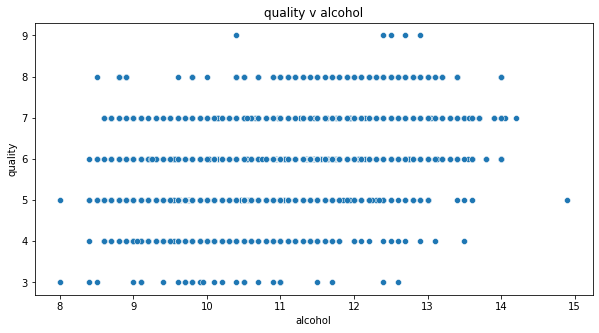

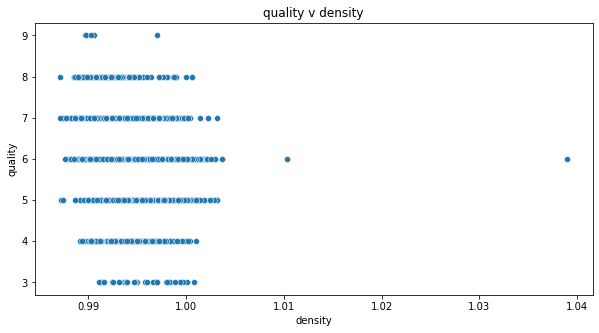

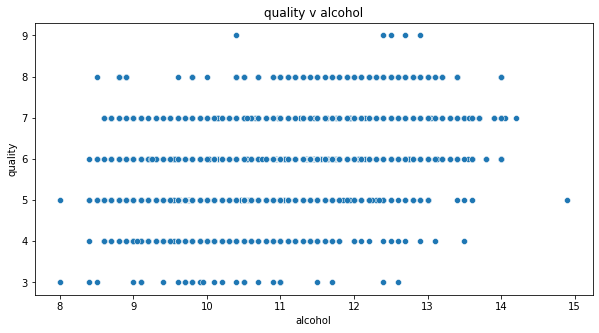

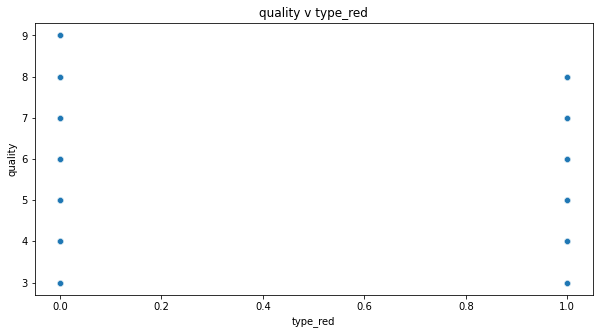

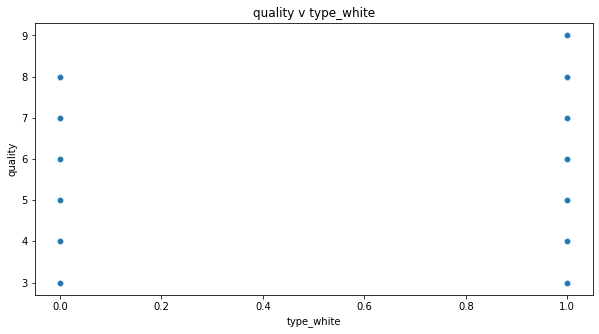

In [17]:

features = corr_feats = ['volatile acidity', 'chlorides', 'density', 'alcohol', 'density', 'alcohol', 'type_red', 'type_white']
target = 'quality'

for feature in features:
    bivariate_analize(wine_df, feature, target, (10,5))